In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler



In [2]:
classes = ["elliptical", "spiral"]
img_channels = list("ugriz")

# roughly 18000 files in each category

# WARNING! - Loading all the imgaes uses lots of RAM
num_images = 10000  

def load_images():
    img_data = []
    labels = []
    for aClass in classes:
        files = glob.glob("../final_data/"+aClass+"/*.npz")
        
        assert num_images < len(files), 'There are not this many images - try a smaller number!'
        
        chosen_files = np.random.choice(files, int(num_images/2), replace=False)
        
        
        for file_name in chosen_files:
            img = np.load(file_name)
            img = np.array(list(map(lambda channel: img[channel], img_channels)))
            img_data.append(img)
            labels.append(classes.index(aClass))

    return img_data, labels

img_data, labels = load_images()
img_data = np.array(img_data)
labels = np.array(labels)


In [3]:
len(labels)

10000

In [4]:
#shuffle the data
shuffle = np.arange(img_data.shape[0])
np.random.shuffle(shuffle)
img_data = img_data[shuffle]
labels = labels[shuffle]
print(f"img_data shape: {img_data.shape}")
# img_data = np.transpose(img_data, (0, 2, 3, 1))
# img_data = img_data/np.amax(img_data)
print(img_data.shape)
print(labels.shape)

img_data shape: (10000, 5, 200, 200)
(10000, 5, 200, 200)
(10000,)


img_data shape: (10000, 5, 200, 200)
Galaxy type: elliptical


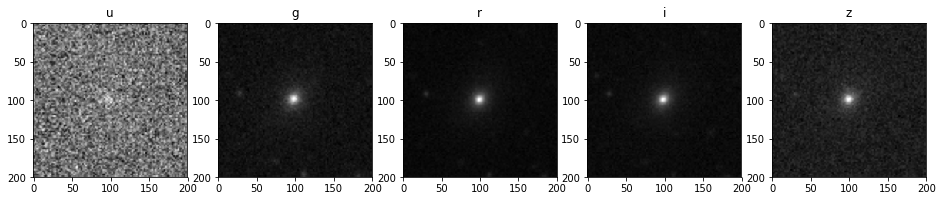

In [5]:
print(f"img_data shape: {img_data.shape}")
img_data = np.transpose(img_data, (0, 2, 3, 1))

fig=plt.figure(figsize=(16, 16))
columns = len(img_channels)
rows = 1
print(f"Galaxy type: {classes[labels[0]]}")
for i in range(0, len(img_channels)):
    img = img_data[0]
    fig.add_subplot(rows, columns, i+1)
    plt.title(img_channels[i])
    plt.imshow(img[:,:,i], cmap="gray")
plt.show()

In [6]:
u_av = []
g_av = []
r_av = []
i_av = []
z_av = []

avs = [u_av, g_av, r_av, i_av, z_av]
galaxy_num = []
for i in range(len(img_data)):

    img = img_data[i]
    galaxy_num.append(i)
    for j in range(5):
        channel_av = np.mean(img[:,:,j])
        avs[j].append(channel_av)

avs = np.array(avs)
avs = np.swapaxes(avs, 0, 1)


In [7]:
# Create a dataframe of the means of each channel value
df = pd.DataFrame(avs)
df.columns = img_channels
df['label'] = labels
df.head()

,u,g,r,i,z,label
0,1028.583250,1085.562225,1177.225825,1275.221600,1146.253525,0
1,1032.005275,1111.688100,1265.551725,1356.231875,1227.095850,1
2,1018.213975,1057.111675,1115.130525,1154.935125,1131.728900,1
3,1020.398525,1095.747525,1164.085550,1229.390225,1146.029350,0
4,1016.015175,1051.739900,1096.851425,1138.234750,1072.815625,0


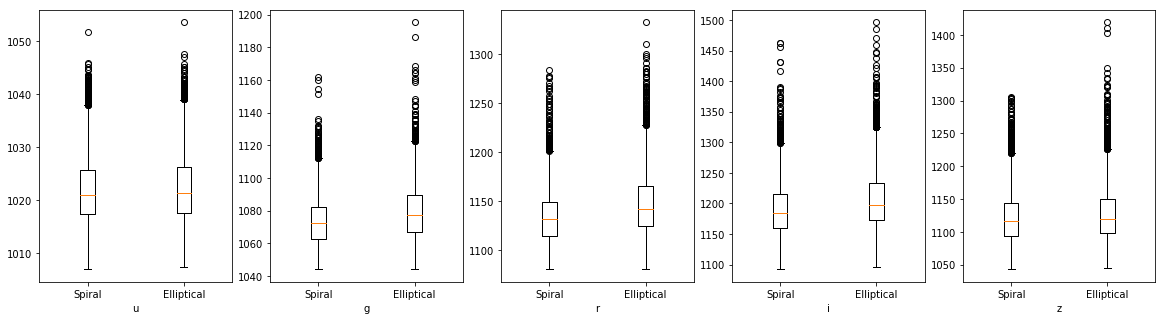

In [8]:
spirals = df.where(df['label'] == 1).dropna()
ellipticals = df.where(df['label'] == 0).dropna()

fig, axes = plt.subplots(1,5, figsize=(20,5))

for i in range(5):

    ax = axes[i]
    ax.boxplot([spirals[img_channels[i]], ellipticals[img_channels[i]]])
    ax.set_xlabel(img_channels[i])
    ax.set_xticklabels(['Spiral', 'Elliptical'])

plt.show()

u        1021.945633
g        1073.900359
r        1134.882379
i        1192.439355
z        1123.294240
label       1.000000
dtype: float64


u        1022.313620
g        1079.126222
r        1147.276531
i        1207.240528
z        1128.389517
label       0.000000
dtype: float64


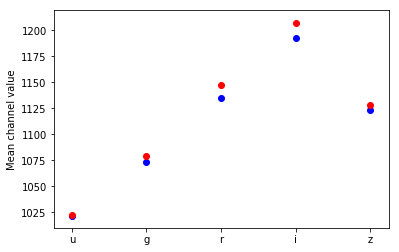

In [9]:
# Plotting the mean of all the means of each channel value
spiral_means = np.mean(df.where(df['label'] == 1))
elliptical_means = np.mean(df.where(df['label'] == 0))

display(spiral_means)
print()
print(elliptical_means)
plt.scatter(img_channels, spiral_means[0:5], c='b')
plt.scatter(img_channels, elliptical_means[0:5], c='r')
plt.ylabel('Mean channel value')
plt.xticks(img_channels)
plt.show()

In [10]:
ols('label ~ u + g + r + i + z', data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     144.1
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          4.27e-148
Time:                        14:59:08   Log-Likelihood:                -6909.9
No. Observations:               10000   AIC:                         1.383e+04
Df Residuals:                    9994   BIC:                         1.388e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.2154      0.937     -9.838      0.000     -11.052      -7.379
u              0.0160      0.001     13.367      0.000       0.014       0.018
g              0.0001      0.001      0.192      0.848      -0.001       0.002
r             -0.0073      0.000    -14.811      0.000      -0.008      -0.006
i              0.0010      0.000      4.360      0.000       0.001       0.002
z              0.0003      0.000      1.547      0.122   -9.14e-05       0.001
==============================================================================
Omnibus:                        0.201   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.904   Jarque-Bera (JB):             1269.287
Skew:                          -0.011   Prob(JB):                    2.39e-276
Kurtosis:                       1.255   Cond. No.                     4.83e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

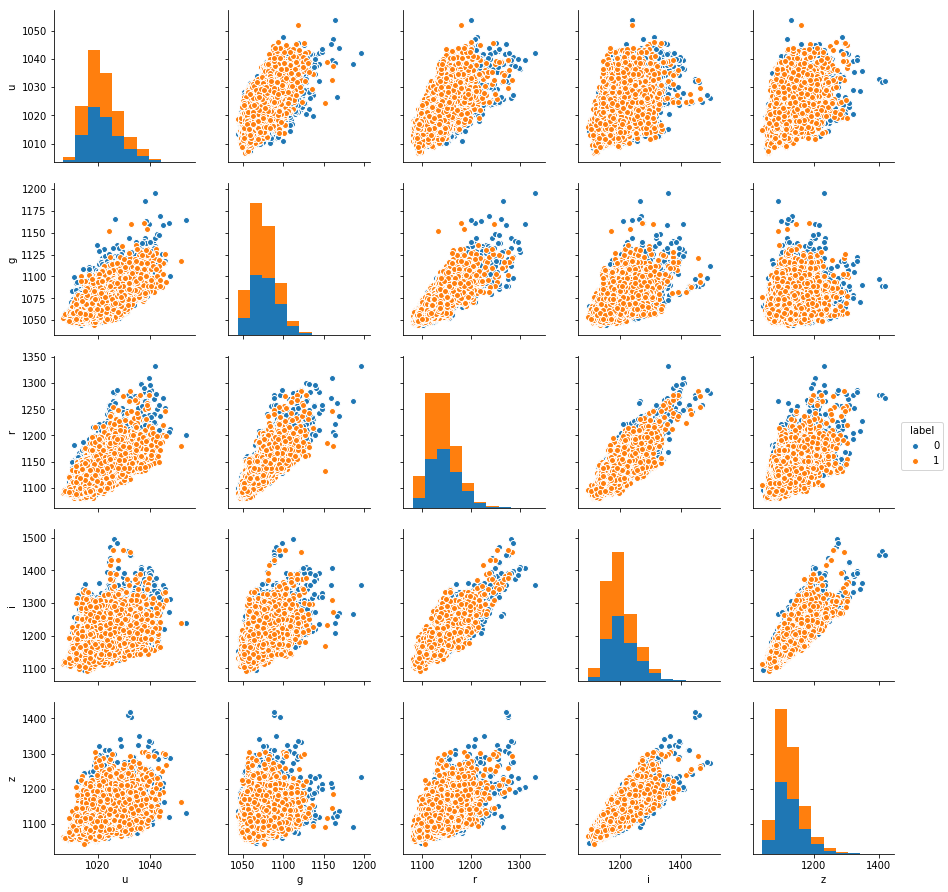

In [11]:
sns.pairplot(data=df, hue='label', vars=list('ugriz'))

In [12]:
y = df.label
X = df.drop('label', axis = 'columns')
# Split into train&validation, test
# Random state assures that folds are consistent across models
Xtrainval, Xtest, ytrainval, ytest = train_test_split(X,y, test_size = 0.10, random_state = 0)
# 10% test data - we should check the actual amount we need  ^^^^^^^^^^^^^^
print(Xtrainval.shape,Xtest.shape)

(9000, 5) (1000, 5)


In [13]:
# linmodel = LinearRegression().fit(Xtrainval,ytrainval)
# trainloss = np.mean((linmodel.predict(Xtrainval) - ytrainval)**2)
# print(f"Training loss: {trainloss}")


logit_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logistic_regression', LogisticRegression()),
])

lr = logit_pipe.fit(Xtrainval,ytrainval)




In [14]:
# cv_scores = cross_val_score(LinearRegression(), Xtrainval, ytrainval, 
#                             cv=5, scoring=make_scorer(mean_squared_error))

# print(cv_scores)
# print(f"CV loss: {cv_scores.mean()}")

tp: 355 tn: 254 fp: 206 fn: 185
Acc: 0.609 Prec: 0.6327985739750446 Rec: 0.6574074074074074
Confusion matrix, without normalization


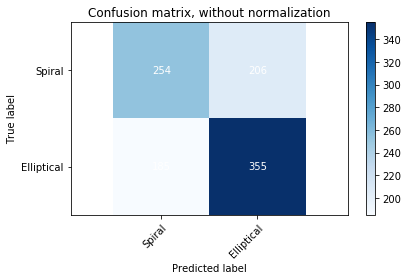

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax



# from sklearn.metrics import plot_confusion_matrix

ytest_pred = lr.predict(Xtest)

tp = sum(np.logical_and(ytest_pred == 1, ytest == 1))
tn = sum(np.logical_and(ytest_pred == 0, ytest == 0))
fp = sum(np.logical_and(ytest_pred == 1, ytest == 0))
fn = sum(np.logical_and(ytest_pred == 0, ytest == 1))
print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")

# Accuracy
trainacc = (tp + tn) / (tp + tn + fp + fn)

# Precision
# "Of the ones I labeled +, how many are actually +?"
precision = tp / (tp + fp)

# Recall
# "Of all the + in the data, how many do I correctly label?"
recall = tp / (tp + fn)  

print("Acc:",trainacc,"Prec:",precision,"Rec:",recall)


plot_confusion_matrix(ytest, ytest_pred, classes=np.array(["Spiral", "Elliptical"]))
